In [2]:
from tabula import read_pdf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import seaborn as sns


# SmartCity Group 4 Notebook
Authors: Catherine Hou, Pan Yeung, Clemente Guasch

## Introduction
**Data:** [Data Surfer SANDAG](http://datasurfer.sandag.org/dataoverview)

**Research Question:**
Why do people commute to work via a car rather than using public transportation, and how can we encourage people to use buses?

In [3]:
# Dataframe for the incomes of all cities by zipcode
income = pd.read_excel('AllCity.xlsx', sheet_name='Household Income')

## Exploratory Data Analysis

### City Height vs. Random High Income City

In [4]:
# Pivot table
income.pivot_table(index="Zip", columns="INCOME", values="NUMBER", aggfunc="sum").head()

INCOME,"$100,000 to $124,999","$125,000 to $149,999","$15,000 to $29,999","$150,000 to $199,999","$200,000 or more","$30,000 to $44,999","$45,000 to $59,999","$60,000 to $74,999","$75,000 to $99,999","Less than $15,000",median income
Zip,,,,,,,,,,,
91901,636.0,427.0,723.0,843.0,548.0,701.0,569.0,560.0,839.0,370.0,80513.0
91902,712.0,306.0,482.0,457.0,494.0,498.0,870.0,754.0,930.0,215.0,76075.0
91905,52.0,25.0,77.0,14.0,7.0,83.0,105.0,48.0,108.0,81.0,53429.0
91906,126.0,58.0,177.0,41.0,22.0,188.0,213.0,106.0,230.0,186.0,53627.0
91910,2092.0,1355.0,3808.0,1376.0,737.0,4125.0,3393.0,2858.0,3376.0,3052.0,54288.0


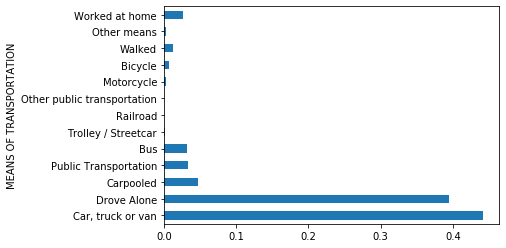

In [5]:
cityheight_type = pd.read_excel('cityHeight.xlsx', sheet_name='Transportation to Work')
cityheight_type["NUMBER"] = cityheight_type["NUMBER"].astype(float)
cityheight_type = cityheight_type.set_index("MEANS OF TRANSPORTATION")
cityheight_type["NUMBER"].apply(lambda x: x/cityheight_type["NUMBER"].sum()).plot(kind="barh")

In [6]:
median_income = income.loc[income["INCOME"]=="median income"].reset_index(drop=True)#.sort_values(by="NUMBER", ascending=False)

In [7]:
high_income = (median_income.loc[median_income["NUMBER"] > 67516])

In [8]:
high_income.sample(1)

,Zip,YEAR,INCOME,NUMBER
67,92091,2010,median income,126907


In [9]:
city_height = pd.read_excel('cityHeight.xlsx', sheet_name='Travel Time to Work')[:-1]
city_height["NUMBER"] = city_height["NUMBER"].astype(float)
city_height=city_height.assign(prop=city_height["NUMBER"].apply(lambda x: x/city_height["NUMBER"].sum()))

In [10]:
travel_time = pd.read_excel('AllCity.xlsx', sheet_name='Travel Time to Work')

In [11]:
high_income_travel_time = travel_time.loc[travel_time["Zip"] == 92091][:-1]
high_income_travel_time["NUMBER"] = high_income_travel_time["NUMBER"].astype(float)
high_income_travel_time=high_income_travel_time.assign(prop=high_income_travel_time["NUMBER"].apply(lambda x: x/high_income_travel_time["NUMBER"].sum()))

In [12]:
merged_data = pd.merge(city_height, high_income_travel_time, on="TRAVEL TIME TO WORK", suffixes=["_cityheight", "_high"])
merged_data = merged_data.set_index('TRAVEL TIME TO WORK')
merged_data

,Zip_cityheight,YEAR_cityheight,NUMBER_cityheight,prop_cityheight,Zip_high,YEAR_high,NUMBER_high,prop_high
TRAVEL TIME TO WORK,,,,,,,,
Did not work at home,92104,2010,24574.0,0.487048,92091,2010,561.0,0.454251
Less than 10 minutes,92104,2010,2271.0,0.045010,92091,2010,53.0,0.042915
10 to 19 minutes,92104,2010,9613.0,0.190526,92091,2010,131.0,0.106073
20 to 29 minutes,92104,2010,6381.0,0.126469,92091,2010,85.0,0.068826
30 to 44 minutes,92104,2010,4339.0,0.085997,92091,2010,235.0,0.190283
45 to 59 minutes,92104,2010,871.0,0.017263,92091,2010,21.0,0.017004
60 to 89 minutes,92104,2010,757.0,0.015003,92091,2010,27.0,0.021862
90 minutes or more,92104,2010,342.0,0.006778,92091,2010,9.0,0.007287
Worked at home,92104,2010,1307.0,0.025904,92091,2010,113.0,0.091498


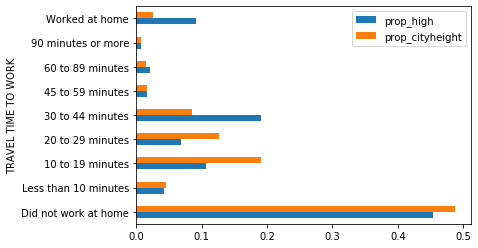

In [13]:
merged_data[['prop_high', 'prop_cityheight']].plot(kind='barh');


### Hypothesis Test
Computing a Hypothesis Test to see whether the distributions of high income cities and city heights are similar for travel time to work.

**Question:** Is the distribution of targetted regions with high spend the same as the distribution of targetted regions in general?

**Null Hypothesis:** The distribution of targetted regions is the same for ones with high spend and in general.

**Alternative Hypothesis:** The distribution of targetted regions is different for ones with high spend and in general.

**Test Statistic:** Total Variation Distance. Because we are seeing if two distributions are different we calculate the tvd to quantify the distance between two categorical distributions.

**Significance Level:** 0.05

In [14]:
def total_variation_distance(dist1, dist2):
    '''Given two empirical distributions, 
    both sorted with same categories, calculates the TVD'''
    return np.sum(np.abs(dist1 - dist2)) / 2

In [15]:
# Calculate observed statistic using TVD
observed_tvd = total_variation_distance(merged_data['prop_high'], merged_data['prop_cityheight'])
observed_tvd

0.1772476937600628

In [16]:
# Simulate null hypothesis
tvds = []

for i in np.arange(1000):
    draw = (np.random.choice(
        merged_data.index, 
        p=merged_data['prop_high'], 
        size=len(merged_data)))
    rand_panel_props = (pd.Series(draw)
                        .value_counts(normalize=True)
                        .rename('random_set'))
    new_tvd = total_variation_distance(rand_panel_props, merged_data['prop_high'])
    tvds.append(new_tvd)

In [17]:
pval = (np.array(tvds) >= observed_tvd).mean()
pval

0.514

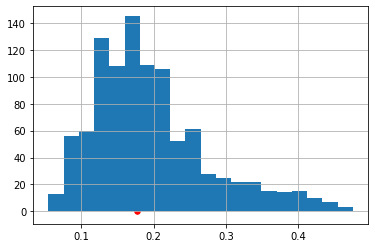

In [18]:
# Empirical distribution of tvd under the null hypothesis
pd.Series(tvds).hist(bins = 20)
plt.scatter(observed_tvd, 0, color='red', s=30);

### Results
* **p-value:** 0.517

* The p-value is greater than the significance level 0.05. This means that we cannot reject the null hypothesis.



### Distributions between LMI and HI

In [19]:
cityheight_type['Zip'].nunique()

1

### Website defining LMI Communities
https://www.sandiego.gov/housing/resources/whatis
>  low- to moderate-income households (persons earning up to 120 percent of area median income)

The San Diego salary median we found is $67516.

After talking to Natasha, perhaps a more appropriate median is $40,000 for LMI.

#### Binning into LMI and HI

In [30]:
# dataframe the holds zipcodes categorized under lmi
lmi = (median_income.loc[median_income["NUMBER"] <= 50000])

In [34]:
# dataframe the holds zipcodes categorized under hi
hi = (median_income.loc[median_income["NUMBER"] > 50000])

There are 84 zip codes categorized under LMI and 24 categorized under HI. A big difference!

In [35]:
lmi_zip=lmi['Zip'].unique()
len(lmi_zip)

21

In [36]:
hi_zip=hi['Zip'].unique()
len(hi_zip)

87

In [38]:
lmi_zip # all the zipcodes under lmi

array([91932, 91942, 91950, 91980, 92004, 92020, 92025, 92055, 92060,
       92066, 92086, 92101, 92102, 92104, 92105, 92113, 92115, 92116,
       92173, 92536, 92672])

#### Clean, Clean, Clean

In [39]:
travel_time_lmi=travel_time.loc[travel_time[['Zip']].isin(lmi_zip)['Zip']]
travel_time_lmi=travel_time_lmi[travel_time_lmi['TRAVEL TIME TO WORK'] != 'Average time to work']
travel_time_lmi.head()

,Zip,YEAR,TRAVEL TIME TO WORK,NUMBER
108,91932,2010,Did not work at home,11622
109,91932,2010,Less than 10 minutes,1061
110,91932,2010,10 to 19 minutes,3348
111,91932,2010,20 to 29 minutes,2715
112,91932,2010,30 to 44 minutes,3105


In [40]:
travel_time_hi=travel_time.loc[travel_time[['Zip']].isin(hi_zip)['Zip']]
travel_time_hi=travel_time_hi[travel_time_hi['TRAVEL TIME TO WORK'] != 'Average time to work']
travel_time_hi.head()

,Zip,YEAR,TRAVEL TIME TO WORK,NUMBER
0,91901,2010,Did not work at home,7689
1,91901,2010,Less than 10 minutes,1302
2,91901,2010,10 to 19 minutes,1117
3,91901,2010,20 to 29 minutes,1535
4,91901,2010,30 to 44 minutes,1985


Apply `groupby` to `TRAVEL TIME TO WORK`

In [41]:
grouped_lmi_travel=travel_time_lmi.groupby('TRAVEL TIME TO WORK')['NUMBER'].agg('sum').to_frame().apply(lambda x: x/x.sum())['NUMBER']
grouped_lmi_travel.to_frame().reset_index()

,TRAVEL TIME TO WORK,NUMBER
0,10 to 19 minutes,0.157359
1,20 to 29 minutes,0.114878
2,30 to 44 minutes,0.096512
3,45 to 59 minutes,0.023574
4,60 to 89 minutes,0.018752
5,90 minutes or more,0.011008
6,Did not work at home,0.487058
7,Less than 10 minutes,0.064975
8,Worked at home,0.025883


In [42]:
grouped_hi_travel=travel_time_hi.groupby('TRAVEL TIME TO WORK')['NUMBER'].agg('sum').to_frame().apply(lambda x: x/x.sum())['NUMBER']
grouped_hi_travel.to_frame().reset_index()

,TRAVEL TIME TO WORK,NUMBER
0,10 to 19 minutes,0.147014
1,20 to 29 minutes,0.120351
2,30 to 44 minutes,0.104697
3,45 to 59 minutes,0.032577
4,60 to 89 minutes,0.021001
5,90 minutes or more,0.009725
6,Did not work at home,0.484205
7,Less than 10 minutes,0.048840
8,Worked at home,0.031590


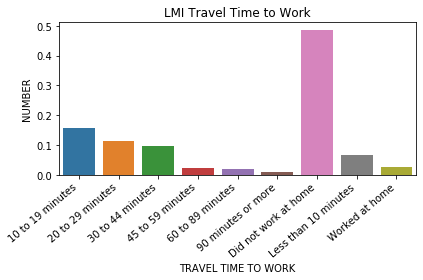

In [43]:
ax = sns.barplot(x="TRAVEL TIME TO WORK", y='NUMBER', data=grouped_lmi_travel.to_frame().reset_index());
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title('LMI Travel Time to Work')
plt.tight_layout()
plt.show()

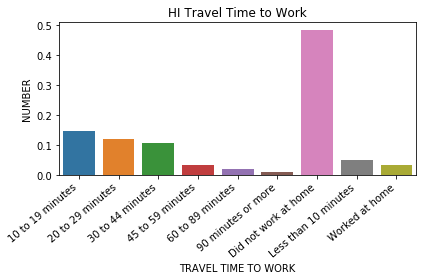

In [44]:
ax = sns.barplot(x="TRAVEL TIME TO WORK", y='NUMBER', data=grouped_hi_travel.to_frame().reset_index());
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
ax.set_title('HI Travel Time to Work')

plt.tight_layout()
plt.show()

### Conclusion:
* The distributions between LMI and HI travel time to work visually look identical.
* It would be too hard to generalize solution for all LMI communities, we may have to look at them individually.
* We may have to look at other metrics and find one where there is a significant difference in the distributions between LMI and HI communities.